## RBM's in Pytorch

In [173]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

In [174]:
import sys
sys.path.append('../')
import ising_analysis
import importlib
importlib.reload(ising_analysis)

<module 'ising_analysis' from '../ising_analysis.py'>

In [175]:
# Turn debuggers off once model is... debugged
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [176]:
# Set pytorch random seed
torch.manual_seed(0)

## Define the model

Energy:
\begin{equation}
E(\sigma,h) = -\sum_{i,j,\alpha} W_{(i-j),\alpha} \sigma_i h_{j,\alpha} -B \sum_i \sigma_i -\sum_{j,\alpha} c_{\alpha} h_{j,\alpha}
\end{equation}

Free energy:
\begin{equation}
\varepsilon(\sigma) = -B \sum_{i=1}^{N} \sigma_i -\sum_{\alpha=1}^M \sum_{j=1}^{N} \ln (1+e^{c_{\alpha}+\sum_{i=1}^{N}W_{(i-j),\alpha}\sigma_i})
\end{equation}

$L$: linear size

$N$: total spins

$M$: hidden neurons per spin

$\sigma_i$: spin unit

$h_{j,\alpha}$: hidden unit

$W_{(i-j),\alpha}$: weight

$i,j \in [0,N-1]$

$\alpha \in [0,M-1]$

In [177]:
# Helper functions

def compute_displacement_vector(vec1,vec2):
    ''' Compute displacement vector between of two vectors '''
    
    return (vec1[0]-vec2[0],vec1[1]-vec2[1])

def unique_displacement_vectors(L):
    ''' Return list of unique displacement vectors as tuples'''
    Δs = []
    for i1 in range(L):
        for j1 in range(L):
            
            for i2 in range(L):
                for j2 in range(L):
                                    
                    Δ = compute_displacement_vector((i1,j1),(i2,j2))
                
                    if Δ not in Δs:
                        Δs.append(Δ)
                    
    return Δs # Get unique Δs

def unique_displacement_vectors_table(L):
    ''' Create lookup table using displacement vectors as keys'''
    
    Δs = unique_displacement_vectors(L)
    
    table = {}
    for i,Δ in enumerate(Δs):
        table[Δ]=i
        
    return table
    
def total_displacement_vectors(table):
    ''' Counts total number of displacement vectors '''
    return len(table)

def flat_to_rowcol(flat_index,L):
    ''' Convert a flat site to row,column format'''
    
    rowcol = [0,0]
    ctr = 0
    for i in range(L):
        for j in range(L):
            
            if ctr == flat_index:
                return (i,j)
            
            ctr += 1
            
def create_flat_to_rowcol_table(L):
    ''' Create table mapping flattened site index to row,column tuple'''
    table = {}
    for flat_index in range(L**2):
        
        table[flat_index] = flat_to_rowcol(flat_index,L)
        
    return table

In [178]:
def R90(Δ):
    '''Get set of four 90-degree rotations of displacement vector Δ'''
    
    R = np.zeros((2,2),dtype=int) # 90 deg rotation matrix for row,col format
    R[0,1] = 1
    R[1,0] = -1
    
    Δ1 = tuple(R@Δ)
    Δ2 = tuple(R@Δ1)
    Δ3 = tuple(R@Δ2)
    
    return [Δ,Δ1,Δ2,Δ3]

def create_unique_rotational_sets(Δs):
    '''Get unique sets of 90 deg rotations of every unique displacement vector'''
    
    all_rotational_sets = []
    for Δ in Δs:
        all_rotational_sets.append(R90(Δ))
        
    for i in range(len(all_rotational_sets)):
        all_rotational_sets[i] = sorted(all_rotational_sets[i])
    all_rotational_sets = sorted(all_rotational_sets)
    
    unique_rotational_sets = []
    for rotational_set in all_rotational_sets:
        if rotational_set not in unique_rotational_sets:
            unique_rotational_sets.append(rotational_set)
        
    return unique_rotational_sets

def rotational_sets_to_flat_indices(unique_rotational_sets,displacements_table):
    '''Map the rotational sets to their corresponding flat indices'''
    
    num_rows = len(unique_rotational_sets)
    num_cols = len(unique_rotational_sets[0])
    full_set = []
    for i in range(num_rows):
        set_i = []
        for j in range(num_cols):
            Δ = unique_rotational_sets[i][j]
            set_i.append(displacements_table[Δ])
            
        full_set.append(set_i)
        
    return full_set

In [6]:
# Definition of symmetry-encoding "RBM" network
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               n_Δ, # total unique displacement vectors
               k=1):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_Δ,n_hin)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(1))       
        self.h_bias = nn.Parameter(torch.zeros(n_hin))   
        self.k = k
    
   def sample_from_p(self,p):
       return torch.nn.functional.relu(torch.sign(p - Variable(torch.rand(p.size())))) # __/
    
   def v_to_h(self,v,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        batch_size = v.shape[0]
        sigmoid_arguments = torch.zeros(batch_size,n_vis,n_hin)
        for batch_index in range(batch_size):
            for j in range(n_vis):
                j_vec = flat_to_rowcol_table[j]
                for α in range(n_hin):
                    c_α = self.h_bias[α]
                    i_sum = 0
                    for i in range(n_vis):
                        i_vec = flat_to_rowcol_table[i]
                        Δ = compute_displacement_vector(i_vec,j_vec)
                        Δ_flat = displacements_table[Δ]

                        i_sum += self.W[Δ_flat,α]*v[batch_index][i]                    

                    sigmoid_arguments[batch_index,j,α] = c_α + i_sum
        
        p_h = torch.sigmoid(sigmoid_arguments)
                
        sample_h = self.sample_from_p(p_h)
        
        return p_h,sample_h
    
   def h_to_v(self,h,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        '''FIX'''
#         p_v = torch.sigmoid(torch.nn.functional.linear(h,self.W.t(),self.v_bias))
        batch_size = h.shape[0]
        sigmoid_arguments = torch.zeros(batch_size,n_vis)
        for batch_index in range(batch_size):
            for i in range(n_vis):
                i_vec = flat_to_rowcol_table[i]
                α_sum = 0
                for α in range(n_hin):
                    B = self.v_bias
                    j_sum = 0
                    for j in range(n_vis):
                        j_vec = flat_to_rowcol_table[j]
                        Δ = compute_displacement_vector(i_vec,j_vec)
                        Δ_flat = displacements_table[Δ]
                        
                        j_sum += self.W[Δ_flat,α]*h[batch_index,j,α]
                        
                    α_sum += j_sum
                    
                sigmoid_arguments[batch_index,i] = B + α_sum
        
        p_v = torch.sigmoid(sigmoid_arguments)
        
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        pre_h1,h1 = self.v_to_h(v,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
            pre_h_,h_ = self.v_to_h(v_,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
        
        return v,v_
    
   def free_energy(self,v,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        '''ε(v) = -B Σ_i v_i - σ Σ_{i,α} ln(1+exp(c_α+Σ_j W_{i-j,α} v_i)) '''
        vbias_term = (v*self.v_bias).sum(1) # Σ_i (v_i*b_i) # Does this work for a batch?
        # NOTE: I will implement the three sums in the dumbest way first
        # Can optimize with built-in Pytorch functions later
        batch_size = v.shape[0]
        hidden_term = torch.zeros(batch_size)
        for batch_index in range(batch_size):
            α_sum = 0
            for α in range(n_hin):
                j_sum = 0
                for j in range(n_vis):
                    i_sum = 0
                    j_vec = flat_to_rowcol_table[j]
                    for i in range(n_vis):
                        i_vec = flat_to_rowcol_table[i]
                        Δ = compute_displacement_vector(i_vec,j_vec)
                        Δ_flat = displacements_table[Δ]

                        i_sum += self.W[Δ_flat,α]*v[batch_index][i]

                    exponent = self.h_bias[α] + i_sum
                    logarithm = torch.log(1+torch.exp(exponent))
                
                    j_sum += logarithm
                    
                α_sum += j_sum
                
            hidden_term[batch_index] += α_sum
                   
        return (-hidden_term - vbias_term).mean()
    
   def symmetrize_rotations(self,R90_sets_flat):
    
        for R90_set in R90_sets_flat:

            W_mean = self.W[R90_set].mean(0)

            with torch.no_grad(): # might actually need it. not sure.
                self.W[R90_set] = W_mean

In [7]:
# Definition of symmetry-encoding "RBM" network
class RBM_vectorized(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               n_Δ, # total unique displacement vectors
               k=1):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_Δ,n_hin)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(1))       
        self.h_bias = nn.Parameter(torch.zeros(n_hin))   
        self.k = k
    
   def sample_from_p(self,p):
       return torch.nn.functional.relu(torch.sign(p - Variable(torch.rand(p.size())))) # __/
    
   def v_to_h(self,v,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        batch_size = v.shape[0]
        sigmoid_arguments = torch.zeros(batch_size,n_vis,n_hin)
        for batch_index in range(batch_size):
            for j in range(n_vis):
                j_vec = flat_to_rowcol_table[j]
                for α in range(n_hin):
                    c_α = self.h_bias[α]
                    i_sum = 0
                    for i in range(n_vis):
                        i_vec = flat_to_rowcol_table[i]
                        Δ = compute_displacement_vector(i_vec,j_vec)
                        Δ_flat = displacements_table[Δ]

                        i_sum += self.W[Δ_flat,α]*v[batch_index][i]                    

                    sigmoid_arguments[batch_index,j,α] = c_α + i_sum
        
        p_h = torch.sigmoid(sigmoid_arguments)
                
        sample_h = self.sample_from_p(p_h)
        
        return p_h,sample_h
    
   def h_to_v(self,h,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        '''FIX'''
#         p_v = torch.sigmoid(torch.nn.functional.linear(h,self.W.t(),self.v_bias))
        batch_size = h.shape[0]
        sigmoid_arguments = torch.zeros(batch_size,n_vis)
        for batch_index in range(batch_size):
            for i in range(n_vis):
                i_vec = flat_to_rowcol_table[i]
                α_sum = 0
                for α in range(n_hin):
                    B = self.v_bias
                    j_sum = 0
                    for j in range(n_vis):
                        j_vec = flat_to_rowcol_table[j]
                        Δ = compute_displacement_vector(i_vec,j_vec)
                        Δ_flat = displacements_table[Δ]
                        
                        j_sum += self.W[Δ_flat,α]*h[batch_index,j,α]
                        
                    α_sum += j_sum
                    
                sigmoid_arguments[batch_index,i] = B + α_sum
        
        p_v = torch.sigmoid(sigmoid_arguments)
        
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        pre_h1,h1 = self.v_to_h(v,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
            pre_h_,h_ = self.v_to_h(v_,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
        
        return v,v_
    
   def free_energy(self,v,n_vis,n_hin,flat_to_rowcol_table,displacements_table):
        '''ε(v) = -B Σ_i v_i - σ Σ_{i,α} ln(1+exp(c_α+Σ_j W_{i-j,α} v_i)) '''
        vbias_term = (v*self.v_bias).sum(1) # Σ_i (v_i*b_i) # Does this work for a batch?
        # NOTE: I will implement the three sums in the dumbest way first
        # Can optimize with built-in Pytorch functions later
        batch_size = v.shape[0]
        hidden_term = torch.zeros(batch_size)
        for batch_index in range(batch_size):
            α_sum = 0
            for α in range(n_hin):
                j_sum = 0
                for j in range(n_vis):
                    i_sum = 0
                    j_vec = flat_to_rowcol_table[j]
                    for i in range(n_vis):
                        i_vec = flat_to_rowcol_table[i]
                        Δ = compute_displacement_vector(i_vec,j_vec)
                        Δ_flat = displacements_table[Δ]

                        i_sum += self.W[Δ_flat,α]*v[batch_index][i]

                    exponent = self.h_bias[α] + i_sum
                    logarithm = torch.log(1+torch.exp(exponent))
                
                    j_sum += logarithm
                    
                α_sum += j_sum
                
            hidden_term[batch_index] += α_sum
                   
        return (-hidden_term - vbias_term).mean()
    
   def symmetrize_rotations(self,R90_sets_flat):
    
        for R90_set in R90_sets_flat:

            W_mean = self.W[R90_set].mean(0)

            with torch.no_grad(): # might actually need it. not sure.
                self.W[R90_set] = W_mean

In [179]:
# Define model
class RBM_normal(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.nn.functional.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = torch.sigmoid(torch.nn.functional.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = torch.sigmoid(torch.nn.functional.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = torch.nn.functional.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [8]:
# # Create tensor of weight element indices
# flat_displacements_indices = torch.ones((n_vis,n_vis),dtype=int)
# for j in range(n_vis):
#     j_vec = flat_to_rowcol_table[j]
#     for i in range(n_vis):
#         i_vec = flat_to_rowcol_table[i]
#         Δ = compute_displacement_vector(i_vec,j_vec)
#         Δ_flat = displacements_table[Δ]
        
#         flat_displacements_indices[j][i] = Δ_flat

In [9]:
# flat_displacements_indices

In [10]:
# Create Ising Dataset object from Monte Carlo data
class CustomIsingDataset(Dataset):
    def __init__(self,spins):
        self.spins = spins
        
    def __len__(self):
        return len(self.spins)
    
    def __getitem__(self,idx):
        spins = self.spins[idx]
        sample = {'spins': spins}
        return sample

In [44]:
# Load spin data
filename = '../uncorrelated_monte_carlo_data/L_8_T_4.0_spins_seed_0.dat'

# Load data from file
spins = np.loadtxt(filename,dtype=np.float32) # network training sometimes breaks for 'double'

# Convert -1's to 0's for RBM compatibility
spins[spins==-1] = 0

# Convert to Python list for dataframe promotion simplicity
spins = list(spins)

# Convert spin data to pandas dataframe
spins_df = pd.DataFrame({'spins':spins})

# Create Dataset object
spins_dataset = CustomIsingDataset(spins_df['spins'])

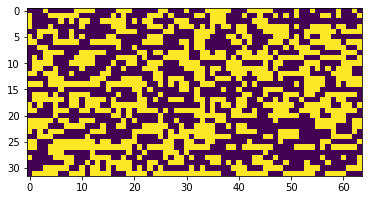

In [45]:
# Show first few rows of loaded Monte Carlo configurations
plt.imshow(spins[0:32])

## Perform train/test split of full dataset

In [57]:
N_full = len(spins_dataset) # total length of full dataset
N_train = int(N_full*0.01)
N_train = 3
N_test = N_full - N_train

print("Full set: ", N_full,'\n')
print("Train set: ", N_train)
print("Test set: ", N_test,'\n')

# To use random_split(), lengths of train/test sets must add up to full. Check.
if (N_train + N_test == N_full): print('Good! Length of splitted sets adds up to full length.') 

Full set:  16000 

Train set:  3
Test set:  15997 

Good! Length of splitted sets adds up to full length.


In [58]:
# Perform random non-overlapping train/test split
train_spins,test_spins = torch.utils.data.random_split(spins_dataset,[N_train,N_test])

In [59]:
# Specify the linear size and temperature
L = 8
T = 4.0

In [60]:
# Compute set of possible displacement vectors
displacements_table = unique_displacement_vectors_table(L)
# table
flat_to_rowcol_table = create_flat_to_rowcol_table(L)

In [61]:
# Get total number of unique displacement vectors
n_Δ = total_displacement_vectors(displacements_table)

In [62]:
# Get all the sets of displacement vectors that are 90 degree rotations of each other
Δs = unique_displacement_vectors(L)
unique_rotational_sets = create_unique_rotational_sets(Δs)
unique_rotational_sets_flat = rotational_sets_to_flat_indices(unique_rotational_sets,displacements_table)

## Initialize and train the model

In [63]:
# Network hyperparamters
N_spins = L**2
n_vis = N_spins
n_hin = N_spins

In [94]:
%%time

# Training parameters
epochs = 20
η = 0.01
batch_size = 1

# Define train and test DataLoaders
train_loader = DataLoader(train_spins, batch_size=batch_size, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_spins, batch_size=batch_size, shuffle=True)

rbm = RBM(n_vis,n_hin,n_Δ,k=1)
train_op = optim.SGD(rbm.parameters(),η)

loss_at_epoch = []
mean_loss = 1
epoch = 0
counter = 0

# free_energy_old = 
for epoch in range(epochs):
    loss_ = []
    for idx, data in enumerate(train_loader): # iterates over batch
        
        sample_data = data['spins']
        # sample_data = Variable(data.view(-1,n_vis)) # This is like a np.reshape(), might be unnecessary
        
        if counter%1==0:
            print("(%d/%d)"%(counter,(epochs*len(list(enumerate(train_loader))))))
        counter += 1
        v,v1 = rbm(sample_data,n_vis,n_hin,flat_to_rowcol_table,displacements_table) # v: input, v1: generated
        loss = rbm.free_energy(v,n_vis,n_hin,flat_to_rowcol_table,displacements_table) - rbm.free_energy(v1,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
        loss_.append(loss.data)
        # train_op.zero_grad()
            for param in rbm.parameters(): # zero out the gradients
                param.grad = None
        loss.backward() # computes loss function gradients
        train_op.step() # updates network parameters
        
        # Symmetrize weights based on 90 degree rotations
        # rbm.symmetrize_rotations(unique_rotational_sets_flat)
        
        # NOTE: Might need to get rid of with torch.no_grad() in function definition
        # History of grad_fn might be important even if we adjust weights manually
        # To-Do: Train and test, then implement the reflection symmetry
        
    # NOTE: Eventually, we can adjust learning rate here using something like:
    # scheduler = ExponentialLR(optimizer, gamma=0.9) --> Defined before loop
    # scheduler.step()
    
    mean_loss = np.mean(loss_)
    loss_at_epoch.append(np.mean(loss_)) # might need to loss_.detach()
    if epoch%1 == 0:
        print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
    epoch += 1
print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

(0/60)
(1/60)
(2/60)
Training loss for 0 epoch: 1605.5582275390625
(3/60)
(4/60)
(5/60)
Training loss for 1 epoch: 1661.6138916015625
(6/60)
(7/60)
(8/60)
Training loss for 2 epoch: 891.625732421875
(9/60)
(10/60)
(11/60)
Training loss for 3 epoch: 443.5789794921875
(12/60)
(13/60)
(14/60)
Training loss for 4 epoch: 119.20194244384766
(15/60)
(16/60)
(17/60)
Training loss for 5 epoch: 71.7898941040039
(18/60)
(19/60)
(20/60)
Training loss for 6 epoch: 44.95335006713867
(21/60)
(22/60)
(23/60)
Training loss for 7 epoch: 29.12760353088379
(24/60)
(25/60)
(26/60)
Training loss for 8 epoch: 15.4658203125
(27/60)
(28/60)
(29/60)
Training loss for 9 epoch: 27.87154197692871
(30/60)
(31/60)
(32/60)
Training loss for 10 epoch: 29.01711082458496
(33/60)
(34/60)
(35/60)
Training loss for 11 epoch: 5.132955074310303
(36/60)
(37/60)
(38/60)
Training loss for 12 epoch: 9.18511962890625
(39/60)
(40/60)
(41/60)
Training loss for 13 epoch: 6.05291748046875
(42/60)
(43/60)
(44/60)
Training loss for 14 

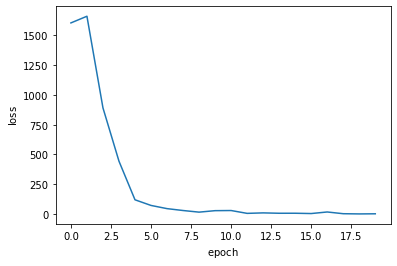

In [103]:
# Plot loss function
loss_at_epoch = np.array(loss_at_epoch)
plt.plot(range(len(loss_at_epoch)),loss_at_epoch)
# plt.yscale('log')
plt.xlabel(r'$\rm epoch$')
plt.ylabel(r'$\rm loss$');

The network is now trained (seemingly).

In [105]:
torch.save(rbm.state_dict(),'./L_8_T_4.0_symmRBM.pt')

In [106]:
rbm = RBM(n_vis,n_hin,n_Δ,k=1)
rbm.load_state_dict(torch.load('./L_8_T_4.0_symmRBM.pt'))
rbm.eval()

RBM()

## Sampling Ising configurations from model

With our trained model, we now want to sample a new set of Ising configuraions according to the model probability distribution.

In [107]:
configs = next(iter(train_loader))['spins'] # grabs a batch of spins from training set
configs.shape

torch.Size([1, 64])

In [108]:
v_in, v_gen = rbm(configs.view(-1, N_spins),n_vis,n_hin,flat_to_rowcol_table,displacements_table)

### Input

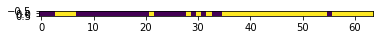

In [109]:
plt.imshow(v_in);

### Generated

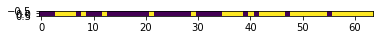

In [110]:
plt.imshow(v_gen.detach().numpy());

### Sampling a longer Markov chain

The above results are for a Markov chain of length 1. As such, these will be very correlated in general. The idea is to start out with a random input and run a longer Markov chain. To test if the RBM samples the correct configurations, I will start out with a ferromagnet configuration (i.e, all spins pointing the same way), and hope that eventually the RBM returns disordered phase configurations instead.

### Plot random walk

In [163]:
%%time

num_walks = 1 # Number of random walks
files = []
filenames = []
for w in range(num_walks):
    # Open file for writing
    filename = "L_8_T_4.0_rbm_walk_"+str(w)+".dat"
    file = open(filename, "w")
    header = "#L=%d, T=%.2f \n# E     M \n"
    file.write(header)
    files.append(file)
    filenames.append(filename)
    
# Number of random walks
# num_walks = 1

# Initialize accumulators 
E = 0.0
M = 0.0

# Set simulation parameters
bins_wanted = 60 # number of samples to generate from the RBM
sweep = L**2 # size of one Monte Carlo sweep
sweep = 1  # I think since update is global, a sweep is now just one update
bin_size = 1 # number of samples  to 
skip = 1 # sweeps performed between measurement
equilibration_steps = 10

# Set counters and/or trackers
bins_written = 0 # counts how many bins have been written to disk
measurement_ctr = 0 # to track if we can write to disk
m = 0 # iteration counter

# Random initial spin config.
v_in.data = torch.bernoulli(torch.rand(N_spins))

while(bins_written<bins_wanted):
            
    # Update input and generated visible vector
    v_in, v_gen = rbm(v_in.view(-1, N_spins),n_vis,n_hin,flat_to_rowcol_table,displacements_table)
    # v_in, v_gen = rbm(v_in,n_vis,n_hin,flat_to_rowcol_table,displacements_table)
    
    # Detach gradients to save memory (since model is trained, grad not needed)
    v_in = v_in.detach()
    v_gen =v_gen.detach()
    v_in = v_gen
            
    # Perform measurement
    if (m%(sweep*skip)==0 and m>=equilibration_steps):
        
        # Unflatten and replace 0's with -1's
        ising_lattice = v_gen.detach().numpy().reshape(L,L)
        ising_lattice[ising_lattice==0] = -1
        
        E += ising_analysis.get_energy(ising_lattice,L)
        M += ising_analysis.get_magnetization(ising_lattice,L)

        measurement_ctr += 1
        
        if (measurement_ctr==bin_size):
            
            # Write to disk
            for w in range(num_walks):
                files[w].write('%.2f %.2f \n'%(E/bin_size,M/bin_size))
                    
            bins_written += 1
            
            if bins_written%1==0:
                print("bins written: (%d/%d)"%(bins_written,bins_wanted))
        
            # Reset counters and accumulators
            measurement_ctr = 0
            # E = np.zeros(num_walks)
            # M = np.zeros(num_walks)
            E = 0
            M = 0
                
    m +=1

            
# Close file          
for w in range(num_walks):
    files[w].close()

bins written: (1/60)
bins written: (2/60)
bins written: (3/60)
bins written: (4/60)
bins written: (5/60)
bins written: (6/60)
bins written: (7/60)
bins written: (8/60)
bins written: (9/60)
bins written: (10/60)
bins written: (11/60)
bins written: (12/60)
bins written: (13/60)
bins written: (14/60)
bins written: (15/60)
bins written: (16/60)
bins written: (17/60)
bins written: (18/60)
bins written: (19/60)
bins written: (20/60)
bins written: (21/60)
bins written: (22/60)
bins written: (23/60)
bins written: (24/60)
bins written: (25/60)
bins written: (26/60)
bins written: (27/60)
bins written: (28/60)
bins written: (29/60)
bins written: (30/60)
bins written: (31/60)
bins written: (32/60)
bins written: (33/60)
bins written: (34/60)
bins written: (35/60)
bins written: (36/60)
bins written: (37/60)
bins written: (38/60)
bins written: (39/60)
bins written: (40/60)
bins written: (41/60)
bins written: (42/60)
bins written: (43/60)
bins written: (44/60)
bins written: (45/60)
bins written: (46/6

In [164]:
!head './L_8_T_4.0_rbm_walk_0.dat'

#L=%d, T=%.2f 
# E     M 
-48.00 26.00 
-20.00 4.00 
-52.00 -18.00 
-100.00 -48.00 
-112.00 -58.00 
-120.00 -62.00 
-120.00 -62.00 
-120.00 -62.00 


In [165]:
filename = './L_8_T_4.0_rbm_walk_0.dat'

In [166]:
rbm_data = np.loadtxt(filename)

In [167]:
# Load rbm_sampled data
rbm_data = np.loadtxt(filename)
rbm_E = rbm_data[:,0]
rbm_M = rbm_data[:,1]

rbm_e = rbm_E/L**2
rbm_m = np.abs(rbm_M)/L**2

In [168]:
np.mean(rbm_E/L**2)

-1.8666666666666667

In [172]:
ising_analysis.e_exact_func(T)

-0.5572722406284901

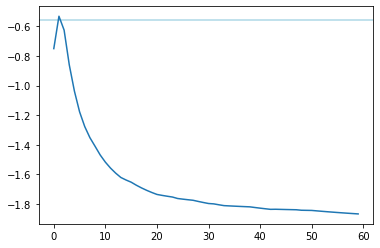

In [169]:
# Plot running average of energy per spin
plt.plot(np.arange(rbm_e.shape[0]),np.cumsum(rbm_e)/np.arange(1,rbm_e.shape[0]+1))
plt.axhline(ising_analysis.e_exact_func(T),zorder=-1,color='lightblue')
# plt.savefig('e_without_abs.pdf',dpi=300)

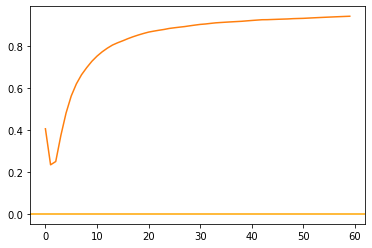

In [171]:
# Plot running average of magnetization per spin
plt.plot(np.arange(rbm_m.shape[0]),np.cumsum(rbm_m)/np.arange(1,rbm_m.shape[0]+1),color='tab:orange')
plt.axhline(0,color='orange',zorder=-1) # USE ACTUAL EXACT FORMULA MAN

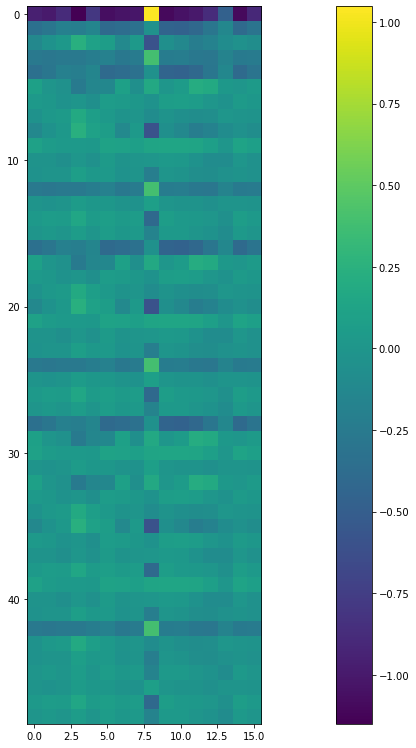

In [52]:
plt.rcParams["figure.figsize"] = [7.00*3, 3.50*3]
plt.rcParams["figure.autolayout"] = True
plt.imshow(rbm.W.detach().numpy())
plt.colorbar()

# References

https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

https://stats.stackexchange.com/questions/114844/how-to-compute-the-free-energy-of-a-rbm-given-its-energy

https://github.com/lisa-lab/DeepLearningTutorials/blob/master/code/rbm.py#L127

https://medium.com/machine-learning-researcher/boltzmann-machine-c2ce76d94da5